In [1]:
import pytorch3d

In [4]:
from r2n2_custom import R2N2
import dataset_location

In [10]:
import torch
from  pytorch3d.datasets.r2n2.utils import collate_batched_R2N2

In [32]:
import mcubes

In [36]:
from pytorch3d.renderer import (
    AlphaCompositor,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    PointsRasterizationSettings,
    PointsRenderer,
    PointsRasterizer,
    HardPhongShader,
)

In [40]:
from pytorch3d.renderer import (
    look_at_view_transform)

In [15]:
    r2n2_dataset = R2N2("train", dataset_location.SHAPENET_PATH, dataset_location.R2N2_PATH, dataset_location.SPLITS_PATH, return_voxels=True, return_feats=False)

    loader = torch.utils.data.DataLoader(
        r2n2_dataset,
        batch_size=1,
        num_workers=0,
        collate_fn=collate_batched_R2N2,
        pin_memory=True,
        drop_last=True)

 category   #instances
----------  ------------
  chair     60990
  total     60990


In [16]:
len(loader)

6099

In [17]:
    r2n2_dataset = R2N2("test", dataset_location.SHAPENET_PATH, dataset_location.R2N2_PATH, dataset_location.SPLITS_PATH, return_voxels=True, return_feats=False)

    loader = torch.utils.data.DataLoader(
        r2n2_dataset,
        batch_size=1,
        num_workers=0,
        collate_fn=collate_batched_R2N2,
        pin_memory=True,
        drop_last=True)
    len(loader)

 category   #instances
----------  ------------
  chair     6780
  total     6780


678

In [22]:
def preprocess(feed_dict):
    images = feed_dict['images'].squeeze(1)
    voxels = feed_dict['voxels'].float()
    ground_truth_3d = voxels
    return images.to("cuda"), ground_truth_3d.to("cuda")

In [23]:
        train_loader = iter(loader)
    
        feed_dict = next(train_loader)

        images_gt, ground_truth_3d = preprocess(feed_dict)

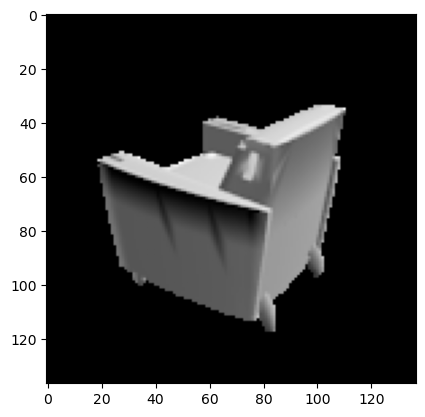

In [27]:
import matplotlib.pyplot as plt
imgplot = plt.imshow(images_gt.squeeze(0).cpu())
plt.show()

In [29]:
print(ground_truth_3d.squeeze(0).squeeze(0).shape)

torch.Size([32, 32, 32])


In [30]:
def render_ground_truth_3d(voxels, image_name):
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
    else:
        device = torch.device("cpu")
    m = torch.nn.Sigmoid()
    vertices_src, faces_src = mcubes.marching_cubes(m(voxels).detach().cpu().squeeze().numpy(), isovalue=0.5)
    vertices_src = torch.tensor(vertices_src).float()
    faces_src = torch.tensor(faces_src.astype(int))
    mesh_src = pytorch3d.structures.Meshes([vertices_src], [faces_src])
    # Get the renderer.
    renderer = get_mesh_renderer(image_size=256)

    center = torch.mean(vertices_src, dim=0)
    #print(center)
    vertices = vertices_src.unsqueeze(0)  # (N_v, 3) -> (1, N_v, 3)

    faces = faces_src.unsqueeze(0)  # (N_f, 3) -> (1, N_f, 3)
    textures = torch.ones_like(vertices)  # (1, N_v, 3)
    color=[0.7, 0.7, 1]
    textures = textures * torch.tensor(color)  # (1, N_v, 3)
    mesh = pytorch3d.structures.Meshes(
        verts=vertices,
        faces=faces,
        textures=pytorch3d.renderer.TexturesVertex(textures),
    )
    mesh = mesh.to(device)
    meshes = mesh.extend(60)

    R, T = look_at_view_transform(dist=40, azim=0, at=(center.numpy(),))

    cameras = pytorch3d.renderer.FoVPerspectiveCameras(device=device, R=R, T=T, fov=60)


    # Place a point light in front of the cow.
    lights = pytorch3d.renderer.PointLights(location=[[0, 0, -3]], device=device)

    rend = renderer(meshes, cameras=cameras, lights=lights)
    # rend = rend.cpu().numpy()[0, ..., :3]  # (B, H, W, 4) -> (H, W, 3)
    rend = rend.cpu().numpy()[..., :3]  # (B, H, W, 4) -> (H, W, 3)
    
    imgplot = plt.imshow(rend[0])
    plt.show()

In [38]:
def get_mesh_renderer(image_size=512, lights=None, device=None):
    """
    Returns a Pytorch3D Mesh Renderer.

    Args:
        image_size (int): The rendered image size.
        lights: A default Pytorch3D lights object.
        device (torch.device): The torch device to use (CPU or GPU). If not specified,
            will automatically use GPU if available, otherwise CPU.
    """
    if device is None:
        if torch.cuda.is_available():
            device = torch.device("cuda:0")
        else:
            device = torch.device("cpu")
    raster_settings = RasterizationSettings(
        image_size=image_size, blur_radius=0.0, faces_per_pixel=1,
    )
    renderer = MeshRenderer(
        rasterizer=MeshRasterizer(raster_settings=raster_settings),
        shader=HardPhongShader(device=device, lights=lights),
    )
    return renderer

/root/miniconda3/envs/pytorch3d/lib/python3.9/site-packages/pytorch3d/renderer/utils.py:298: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1666642975993/work/torch/csrc/utils/tensor_new.cpp:230.)
  input = torch.tensor(input, dtype=dtype, device=device_)


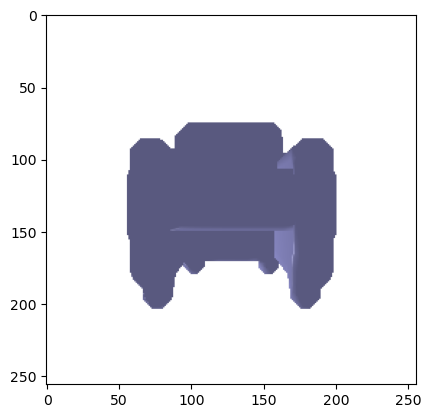

In [41]:
render_ground_truth_3d(ground_truth_3d, "test")